In [4]:
import torch
import numpy as np
from torch import optim
import torch.nn as nn
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import random

import Generator
import Encoder
import TempEncoder
# Global defs

# iters_per_epoch should also be shifted here ?

%load_ext autoreload
%autoreload 2

In [5]:
from torch.autograd import Variable
use_cuda = torch.cuda.is_available()

In [6]:
num_samples = 1
batch_size = 64

MASTER_MAX_LEN = 300
MASTER_MAX_VAL_LEN = 400

In [7]:
# Function defs
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

def asMinutes(s):
	m = math.floor(s / 60)
	s -= m * 60
	return '%dm %ds' % (m, s)

def timeSince(since, percent):
	now = time.time()
	s = now - since
	es = s / (percent + 1e-8)
	rs = es - s
	return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [8]:
# ** Starting of the Main code 
# ** ** 
# ** ** 
import re

# Convert string to vector of floats
def convert_to_float(string): # string with float values separated by spaces
	lis = string.split()
	lis_rating = [ float(value) for value in lis]
	return lis_rating

# Unique index for words
index = 0
def get_index():
	global index
	to_ret = index
	index += 1
	return to_ret

# Dictionaries
dict_ind2vec = {}
dict_ind2str = {}
dict_str2ind = {}

def get_list_of_indices(string):
	lis_words = string.split()
	# lis_ret = [ for word in lis_words]
	lis_ret = []
	for word in lis_words:
		try:
			ind_append = dict_str2ind[word]
			lis_ret.append(ind_append)
		except:
			pass
			# ind_append = 
			# print("THERE IT IS!", word)
	# print("About to return")
	return lis_ret

## **
## **
# read the word2vec representations

with open('../review+wiki.filtered.200.txt') as f:
	wordvecs = f.readlines()

first_pair = wordvecs[0].split(" ", 1)
first_vec = convert_to_float(first_pair[1])
dim_vecSpace = len(first_vec) # Dimension of the vector space in which we are

# add stuff for EOS, Blank
# at index = 0, 1

eos_index = get_index()
dict_str2ind["<EOS>"] = eos_index
dict_ind2str[eos_index] = "<EOS>"
dict_ind2vec[eos_index] = [1.0]*dim_vecSpace

blk_index = get_index()
dict_str2ind["<BLANK>"] = blk_index
dict_ind2str[blk_index] = "<BLANK>"
dict_ind2vec[blk_index] = [0.0]*dim_vecSpace


for elem in wordvecs:
	liss = elem.split(" ", 1) # split on the first space
	word_str = liss[0]
	word_vec = convert_to_float(liss[1])
	
	here_index = get_index()
	dict_str2ind[word_str] = here_index
	dict_ind2str[here_index] = word_str
	dict_ind2vec[here_index] = word_vec

# CHKING
# print( dict_str2ind['a'] )

## **
## **
# read the data

with open('../reviews.aspect0.train.txt') as f:
	train_data = f.readlines()

rating_regex = re.compile('\d\.\d\d \d\.\d\d \d\.\d\d \d\.\d\d \d\.\d\d\t') # Exactly matches only the ratings

# extract ratings - # each rating is a scalar value # NO ::: each rating is a list of 5 values
ratings = [ float( re.findall(rating_regex, review)[0][0] ) for review in train_data ]

# extract reviews
reviews_str = [ rating_regex.sub('', review) for review in train_data ]
reviews = [ get_list_of_indices( review_str ) for review_str in reviews_str ]
X = reviews
total_size = len(X)

divide_train = int( (4*total_size)/5 )
train_indices_of_X = sorted( random.sample( range(total_size), divide_train ) )

X_train = []
X_val = []
ratings_train = []
ratings_val = []
for i in range(total_size):
	if i in train_indices_of_X:
		X_train.append(X[i])
		ratings_train.append(ratings[i])
	else:
		X_val.append(X[i])
		ratings_val.append(ratings[i])

X = X_train
ratings = ratings_train

num_train_examples = len(X) # we also assume len(X) = len(ratings)
num_val_examples = len(X_val)
# read validation data

# ** ** 
# ** ** 

In [9]:
def getAccuracy(X, ratings, encoder, generator):

    # iterate through X_val and pass to generator->encoder to get mse_error and compare it to truth
    num_val_examples = len(X)
    X_val_size = num_val_examples
    num_iters = X_val_size // (batch_size)
    total_loss = 0.0
    for iters in range(num_iters):

        # get X_batch, ratings_batch
        # This sampling also preserves the order
        X_bch = []
        ratings_bch = []

        _ = [ ( X_bch.append(X[i]) , ratings_bch.append(ratings[i]) ) for i in sorted(random.sample(range(num_val_examples), batch_size)) ]

        # almost done here - make all the reviews of equal length now

        maxlen_rev = max(X_bch, key=len)
        maxlen = len(maxlen_rev)

        max_seq_len = min(maxlen, MASTER_MAX_VAL_LEN)
        
        
        X_bach = np.empty([batch_size,max_seq_len])
        ratings_bach = np.empty([batch_size,1])

        for iterr in range(batch_size):
            currentlen = len(X_bch[iterr])
            if (currentlen < max_seq_len):
                zero_count = max_seq_len - currentlen
                X_bch[iterr].extend([0]*zero_count)
            else:
                X_bch[iterr] = X_bch[iterr][0:max_seq_len]
            # X_bch[iterr] is now a list containing indices of words
            # Convert it into a Variable ?
            to_append = np.array( X_bch[iterr] )
            X_bach[iterr] = to_append
            to_append = np.array( ratings_bch[iterr] )
            ratings_bach[iterr] = to_append
        # X_bach is a 2d numpy array of size :: batch_size X maxlen

        if (use_cuda):
            X_bach_tensor = torch.from_numpy(X_bach).type(torch.LongTensor).cuda()
            ratings_bach_tensor = torch.from_numpy(ratings_bach).type(torch.FloatTensor).cuda()
        else:
            X_bach_tensor = torch.from_numpy(X_bach).type(torch.LongTensor)
            ratings_bach_tensor = torch.from_numpy(ratings_bach).type(torch.FloatTensor)

        X_batch = Variable(X_bach_tensor)
        ratings_batch = Variable(ratings_bach_tensor)

#         init_hidden = generator.initHidden(batch_size, use_cuda)
#         z_sample = generator.sample(X_batch, init_hidden, use_cuda)

        ratings_pred = encoder(X_batch, None, False)
        encoderLoss = nn.MSELoss(reduce=False)
        encoder_loss = encoderLoss(ratings_pred, ratings_batch.squeeze(1))

        total_loss += float(torch.sum(encoder_loss))

    return total_loss / X_val_size

In [10]:
# Train function - here's some ingenuity
# one iteration of training
def train(X, ratings, encoder, generator, encoder_optimizer, generator_optimizer, \
          length_reg, continuity_reg, print_grad_norm):
    # X - single batch

    encoder_optimizer.zero_grad()
    generator_optimizer.zero_grad()

    encoderLoss = nn.MSELoss(reduce=False)

    mean_cost = 0.0
    mean_encoder_cost = 0.0
    for i in range(num_samples):
#         init_hidden = generator.initHidden(batch_size, use_cuda)
#         z_sample = generator.sample(X, init_hidden, use_cuda)
#         z_sample = Variable(torch.zeros((batch_size, X.shape[1])))
#         z_sample = z_sample.detach()

        ratings_pred = encoder(X, None)
        encoder_loss = encoderLoss(ratings_pred, ratings.squeeze(1))

#         init_hidden = generator.initHidden(batch_size, use_cuda)
#         length_cost, continuity_cost = generator.loss(z_sample)

#         cost = encoder_loss + length_cost * length_reg + continuity_cost * continuity_reg
        cost = encoder_loss
       

#         log_prob = generator.logProb(X, z_sample, init_hidden, use_cuda)

#         log_prob.backward(1.0 / (num_samples * batch_size) * cost)
#         cost.backward(torch.Tensor([1.0 / (batch_size * num_samples)] * batch_size))
        cost1 = torch.mean(cost)
    
        mean_cost += float(cost1)
        mean_encoder_cost += float(torch.mean(encoder_loss))
        
        cost1 /= num_samples
        cost1.backward()
        
        
    if (print_grad_norm):
        for name, param in encoder.named_parameters():
            if param.requires_grad:
                print(name)
                print(param.data.norm())
                print (param.grad.data.norm())
                
        input()
    
    encoder_optimizer.step()
#     generator_optimizer.step()
    
    
    mean_cost /= num_samples
    mean_encoder_cost /= num_samples
    return mean_cost, mean_encoder_cost

In [11]:
def trainIters(X, ratings, X_val, ratings_val, encoder, generator, learning_rate, learning_rate_decay, num_epochs, \
               length_reg, continuity_reg, load_dict=None, print_every=1000, plot_every=100, val_every=1000, print_grad_every=-1, \
                save_folder=''):

    
    num_train_examples = len(X)
    start = time.time()
    plot_losses = []
    print_loss_total = 0.0
    print_encoder_loss_total = 0.0
    plot_loss_total = 0.0
    best_val_acc = float("inf")
    if load_dict is not None:
        encoder = load_dict['encoder_model']
        generator = load_dict['generator_model']
        
        cur_tot_iters = load_dict['tot_iter']
    else:
        cur_tot_iters = 0
        
    enc_param_list = []
    for param in encoder.parameters():
        if (param.requires_grad):
            enc_param_list.append(param)
    encoder_optimizer = optim.Adam(enc_param_list, lr=learning_rate)

    gen_param_list = []
    for param in generator.parameters():
        if (param.requires_grad):
            gen_param_list.append(param)
    generator_optimizer = optim.Adam(gen_param_list, lr=learning_rate)
    
        
    encoder_scheduler = optim.lr_scheduler.StepLR(encoder_optimizer, 1, learning_rate_decay)
    generator_scheduler = optim.lr_scheduler.StepLR(generator_optimizer, 1, learning_rate_decay)
    
    if (load_dict is not None):
        encoder_optimizer.load_state_dict(load_dict['encoder_optimizer'])
#         for param_group in encoder_optimizer.param_groups:
#             param_group['lr'] = learning_rate
        generator_optimizer.load_state_dict(load_dict['generator_optimizer'])
        encoder_scheduler.load_state_dict(load_dict['encoder_scheduler'])
        generator_scheduler.load_state_dict(load_dict['generator_scheduler'])

#     print(encoder_optimizer.param_groups[0]['lr'])
     # set iters_per_epoch
    iters_per_epoch = num_train_examples // batch_size
    n_iters = iters_per_epoch * num_epochs
    
    position_set = False
    for epoch in range(num_epochs):
        if (position_set):
            encoder_scheduler.step()
            generator_scheduler.step()
        for iter_num in range(iters_per_epoch):
            if (cur_tot_iters >= epoch * iters_per_epoch + iter_num + 1):
                continue
            
            position_set = True
            # randomly choose sample from X and make them equal length
            # This sampling also preserves the order
            X_bch = []
            ratings_bch = []

            _ = [ ( X_bch.append(X[i]) , ratings_bch.append(ratings[i]) ) for i in sorted(random.sample(range(num_train_examples), batch_size)) ]

            # almost done here - make all the reviews of equal length now

            maxlen_rev = max(X_bch, key=len)
            maxlen = len(maxlen_rev)

            max_seq_len = min(maxlen, MASTER_MAX_LEN)
            
            X_bach = np.empty([batch_size,max_seq_len])
            ratings_bach = np.empty([batch_size,1])

            for iterr in range(batch_size):
                currentlen = len(X_bch[iterr])
                if (currentlen < max_seq_len):
                    zero_count = max_seq_len - currentlen
                    X_bch[iterr].extend([0]*zero_count)
                else:
                    X_bch[iterr] = X_bch[iterr][0:max_seq_len]
                # X_bch[iterr] is now a list containing indices of words
                # Convert it into a Variable ?
                to_append = np.array( X_bch[iterr] )
    # 				X_bach = np.append(X_bach, [to_append], axis = 0)
                X_bach[iterr] = to_append
                to_append = np.array( ratings_bch[iterr] )
    # 				ratings_bach = np.append(ratings_bach, to_append, axis = 0)
                ratings_bach[iterr] = to_append
            # X_bach is a 2d numpy array of size :: batch_size X maxlen

            if (use_cuda):
                X_bach_tensor = torch.from_numpy(X_bach).type(torch.LongTensor).cuda()
                ratings_bach_tensor = torch.from_numpy(ratings_bach).type(torch.FloatTensor).cuda()
            else:
                X_bach_tensor = torch.from_numpy(X_bach).type(torch.LongTensor)
                ratings_bach_tensor = torch.from_numpy(ratings_bach).type(torch.FloatTensor)
            X_batch = Variable(X_bach_tensor)
            ratings_batch = Variable(ratings_bach_tensor)
            # call train with this batch
            cur_tot_iters = iter_num + 1 + epoch * iters_per_epoch
            if (print_grad_every > 0 and cur_tot_iters % print_grad_every == 0):
                cur_loss, cur_encoder_loss = train(X_batch, ratings_batch, encoder, generator, \
                                                   encoder_optimizer, generator_optimizer, length_reg, continuity_reg, True)
            else:
                cur_loss, cur_encoder_loss = train(X_batch, ratings_batch, encoder, generator, \
                                               encoder_optimizer, generator_optimizer, length_reg, continuity_reg, False)
            
            print_loss_total += cur_loss
            print_encoder_loss_total += cur_encoder_loss
            plot_loss_total += cur_loss

            
          
            if (cur_tot_iters) % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_encoder_loss_avg = print_encoder_loss_total / print_every
                print_loss_total = 0
                print_encoder_loss_total = 0
                print('%s (%d %d%%) %.4f %.4f' % (timeSince(start, 1.0 * (cur_tot_iters) / n_iters),
                                             cur_tot_iters, 1.0 * (cur_tot_iters) / n_iters * 100, print_loss_avg, print_encoder_loss_avg),flush=True)
            
            if (cur_tot_iters) % val_every == 0:
                val_acc = getAccuracy(X_val, ratings_val, encoder, generator)
                print("Val Acc: ", val_acc)
                if (val_acc < best_val_acc):
                    best_val_acc = val_acc
                    best = True
                else:
                    best = False
                    
                save_dict = {}
                save_dict['encoder_model'] = encoder
                save_dict['generator_model'] = generator
                save_dict['encoder_optimizer'] = encoder_optimizer.state_dict()
                save_dict['generator_optimizer'] = generator_optimizer.state_dict()
                save_dict['encoder_scheduler'] = encoder_scheduler.state_dict()
                save_dict['generator_scheduler'] = generator_scheduler.state_dict()
                
                save_dict['tot_iter'] = cur_tot_iters
                save_dict['val_acc'] = val_acc
                save_dict['best_so_far'] = best
                torch.save(save_dict, save_folder+'chkpt_'+str(cur_tot_iters)+str(best))

            if iter_num % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0

    showPlot(plot_losses)

In [12]:
# defining pretrained_embeddings
pretrained_embeddings = np.empty([len(dict_ind2vec), dim_vecSpace])
for key in sorted(dict_ind2vec.keys()):
    vec_here = dict_ind2vec[key]
    pretrained_embeddings[key] = np.array(vec_here)

In [13]:
if use_cuda:
    print("Using GPU")
else:
    print("Using CPU")

Using GPU


In [17]:
load_dict = torch.load('only_enc2/chkpt_50000False')
# encoder = None
# generator = None


/home/ubuntu1604/temp/code/project_code/enc_gen_model/Encoder.py:42: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  output, (_, _) = self.lstm_i2h(x)


0m 5s (- 0m 1s) (50100 83%) 0.0418 0.0418
Val Acc:  0.06422075743507594
0m 19s (- 0m 3s) (50200 83%) 0.0391 0.0391
Val Acc:  0.0649057505428791
0m 32s (- 0m 6s) (50300 83%) 0.0432 0.0432
Val Acc:  0.06840119893662631
0m 46s (- 0m 8s) (50400 84%) 0.0480 0.0480
Val Acc:  0.06797810227051378
1m 0s (- 0m 11s) (50500 84%) 0.0404 0.0404
Val Acc:  0.0676291267387569
1m 13s (- 0m 13s) (50600 84%) 0.0429 0.0429
Val Acc:  0.06888680682331323
1m 27s (- 0m 16s) (50700 84%) 0.0408 0.0408
Val Acc:  0.07011943362466991
1m 41s (- 0m 18s) (50800 84%) 0.0431 0.0431
Val Acc:  0.06813179255276919
1m 55s (- 0m 20s) (50900 84%) 0.0438 0.0438
Val Acc:  0.06589603094756603
2m 8s (- 0m 22s) (51000 85%) 0.0413 0.0413
Val Acc:  0.06773627009242773
2m 22s (- 0m 24s) (51100 85%) 0.0395 0.0395
Val Acc:  0.07258052104339004
2m 36s (- 0m 26s) (51200 85%) 0.0412 0.0412
Val Acc:  0.06905434950068592
2m 50s (- 0m 28s) (51300 85%) 0.0427 0.0427
Val Acc:  0.06715524130221456
3m 4s (- 0m 30s) (51400 85%) 0.0440 0.0440
Val 

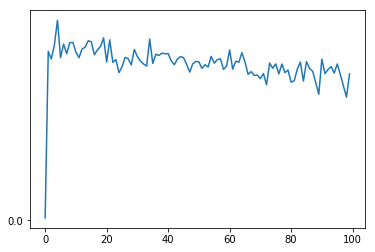

In [18]:
# Initialing hyperparam containers
learning_rates = [0.007]
length_regs = [0.0003]
continuity_regs = [0.0006]
learning_rate_decays = [0.95]
num_epochs = 60
gen_hidden_dim = 200
gen_num_layers = 1
gen_s_size = 30

# load_dict=None
for lrate_decay in learning_rate_decays:
	for length_reg in length_regs:
		for continuity_reg in continuity_regs:
			for l_rate in learning_rates:
				generator = Generator.Generator(gen_hidden_dim, gen_num_layers, gen_s_size, pretrained_embeddings, 'LSTM')
				# fill encoder parameters
				encoder = Encoder.Encoder(200, 2, pretrained_embeddings, 'LSTM', dropout=0.1)
				encoder.float()
				generator.float()
                
				if (use_cuda):
					encoder.cuda()
					generator.cuda()
                    
				trainIters(X, ratings, X_val, ratings_val, encoder, generator, 
							learning_rate=l_rate, learning_rate_decay=lrate_decay, num_epochs=num_epochs, 
							length_reg=length_reg, continuity_reg=continuity_reg, \
                            print_every=100,val_every=100,load_dict=load_dict, print_grad_every=-1, \
                          save_folder='only_enc2/')

In [124]:
toy_X = [[2], [1]]
toy_ratings = [[0.2], [0.1]]
toy_X_val = [[2]]
toy_ratings_val = [[0.2]]
load_dict=None


In [16]:
load_dict = torch.load('toy/chkpt_49900False')


FileNotFoundError: [Errno 2] No such file or directory: 'toy/chkpt_49900False'

In [144]:
learning_rates = [0.5]
length_regs = [0.0003]
continuity_regs = [0.0006]
learning_rate_decays = [1]
num_epochs = 100000
gen_hidden_dim = 200
gen_num_layers = 1
gen_s_size = 30

# load_dict=None
generator=None
for lrate_decay in learning_rate_decays:
    for length_reg in length_regs:
        for continuity_reg in continuity_regs:
            for l_rate in learning_rates:
                generator = Generator.Generator(gen_hidden_dim, gen_num_layers, gen_s_size, pretrained_embeddings, 'LSTM')
                encoder = TempEncoder.TempEncoder(1, 1, pretrained_embeddings, 'RNN', dropout=0.1)
                encoder.float()
                generator.float()
    
                if (use_cuda):
                    encoder.cuda()
                    generator.cuda()
                trainIters(toy_X, toy_ratings, toy_X_val, toy_ratings_val, encoder, generator, \
                                        learning_rate=l_rate, learning_rate_decay=lrate_decay, num_epochs=num_epochs, 
                                        length_reg=length_reg, continuity_reg=continuity_reg, \
                                        print_every=100,val_every=1000,load_dict=load_dict, print_grad_every=-1, \
                                       save_folder='toy/')

0.5
0m 0s (- 3m 58s) (100 0%) 0.0877 0.0877
0m 0s (- 4m 8s) (200 0%) 0.0050 0.0050
0m 0s (- 4m 7s) (300 0%) 0.0113 0.0113
0m 0s (- 4m 11s) (400 0%) 0.0074 0.0074
0m 0s (- 4m 15s) (500 0%) 0.0080 0.0080
0m 0s (- 4m 15s) (600 0%) 0.0084 0.0084
0m 0s (- 4m 12s) (700 0%) 0.0082 0.0082
0m 1s (- 4m 9s) (800 0%) 0.0049 0.0049
0m 1s (- 4m 6s) (900 0%) 0.0057 0.0057
h2o.weight
tensor(1.00000e-20 *
       1.3882, device='cuda:0')
tensor(1.00000e-21 *
       1.3021, device='cuda:0')
h2o.bias
tensor(0.1455, device='cuda:0')
tensor(0.1090, device='cuda:0')
i2h.weight
tensor(1.00000e-21 *
       7.8079, device='cuda:0')
tensor(1.00000e-21 *
       3.0252, device='cuda:0')
i2h.bias
tensor(1.00000e-21 *
       3.6645, device='cuda:0')
tensor(1.00000e-21 *
       1.5127, device='cuda:0')


KeyboardInterrupt: 